# Proyecto 1 - Manuel Murguia
### Deep Learning

<p style = "text-align: justify"> En este proyecto, exploramos la generación de imágenes de paisajes utilizando autoencoders, redes neuronales capaces de comprimir y descomprimir datos. Nos centraremos en la arquitectura de autoencoder variacional (VAE), que no solo puede reconstruir imágenes, sino también generar nuevas muestras del espacio latente aprendido. Nuestro objetivo es crear paisajes realistas y estéticamente agradables, abordando desafíos como la diversidad y la calidad de las imágenes generadas.

#### Importación de Librerias

In [1]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
import numpy as np
import zipfile
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

#### Conexión a Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/DeepLearning/Proyecto1/archive.zip"

directory_path = "/content/images"

# Crear el directorio de destino si no existe
os.makedirs(directory_path, exist_ok=True)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(directory_path)

Este código no es nada especial, simplemente definimos las rutas dentro del google drive donde se encuentra el archivo zip con las imagenes y donde queremos depositarlas

#### Train y Test

In [4]:
# Función para cargar las imágenes
def load_images_from_folder(folder, target_size = (32, 32)): #------------------------------------------------------------------------------- size en vez de 32
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            # Redimensionar la imagen
            img = img.resize(target_size)

            # Convertir a formato RGB y asegurarse de que tenga solo 3 canales
            img = img.convert('RGB')
            images.append(np.array(img))

            # Asigna una etiqueta (por ejemplo, 0 para entrenamiento, 1 para prueba)
            labels.append(0 if random.random() < 0.8 else 1)
    return images, labels

# Directorio donde están tus imágenes
root_directory = "/content/images"

# Cargar las imágenes y las etiquetas
images, labels = load_images_from_folder(root_directory)

# Dividir las imágenes y las etiquetas en conjuntos de entrenamiento y prueba
x_train = []
y_train = []
x_test = []
y_test = []

for img, label in zip(images, labels):
    if label == 0:
        x_train.append(img)
        y_train.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

# Convertir listas a numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print('Dimensiones de x_train:', x_train.shape)
print('Dimensiones de x_test:', x_test.shape)

Dimensiones de x_train: (3448, 32, 32, 3)
Dimensiones de y_train: (3448,)
Dimensiones de x_test: (871, 32, 32, 3)
Dimensiones de y_test: (871,)


El código anterior nos separa nuestro dataset en train y test. El train lo usaremos para entrenar nuestro modelo mientras que el test servirá para comprobar la funcionalidad de nuestro modelo.

#### Imagen de Ejemplo

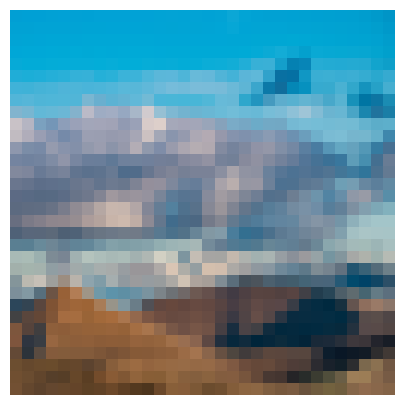

In [5]:
# Convertir el lote de imágenes a un arreglo NumPy
images = x_train

# Seleccionar una imagen aleatoria del lote
index = np.random.randint(len(images))

image = images[0]

# Mostrar la imagen
plt.figure(figsize = (5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

Aquí podemos ver como se vería una imagen aleatoria del dataset de entrenamiento

In [6]:
x_train.shape[1:]

(32, 32, 3)

Y sus dimensiones

In [7]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

normalizamos los pixeles de las imágenes

In [8]:
input_shape = x_train.shape[1:]
batch_size = 64
latent_dim = 64
epochs = 15

y definimos nuestros parámetros. Cabe mencionar que estos parámetros fueron definidos déspues de varias pruebas, no los obtuve de manera aleatoria, simplemente fueron los que mejor resultado me dieron.

In [9]:
inputs = Input(shape = input_shape, name = "encoder_input")
x = Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(inputs)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding =  "same")(x)

shape_before_flat = K.int_shape(x)

x = Flatten()(x)
x = Dense(256, activation = "relu" )(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

El código anterior define la parte del "encoder" de un autoencoder variacional, que toma una entrada de imagen, la procesa a través de capas convolucionales y capas densas, y produce la media y la varianza de la distribución latente.

In [10]:
def sampling(args):
  z_mean, z_log_var = args

  dim = K.int_shape(z_mean)[1]

  # TODO: check dimensions
  epsilon = K.random_normal(shape = (K.shape(z_mean)[0], dim))

  return z_mean + K.exp(0.5 * z_log_var) * epsilon

<p style = "text-align: justify"> El código define una función llamada sampling para un autoencoder especial llamado autoencoder variacional (VAE). Esta función es como la imaginación del modelo: toma una idea general (la media y la varianza) y la convierte en algo específico y nuevo. Utiliza una especie de truco matemático para agregar un poco de variabilidad a las muestras que genera, lo que le da al modelo la capacidad de crear imágenes diferentes cada vez que lo usamos. Es como si estuviera añadiendo un poco de especias a una receta básica para hacerla más emocionante y variada. </p>

In [11]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

esta línea de código crea una capa en el modelo VAE que toma la media y el logaritmo de la varianza de la distribución latente como entrada y genera muestras en el espacio latente utilizando la función sampling.

# Encoder

In [12]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 4096)                 0         ['conv2d_1[0][0]']            
                                                                                            

este fragmento de código crea y muestra un resumen del modelo encoder, que toma una entrada y produce la media (z_mean) y el logaritmo de la varianza (z_log_var) de la distribución latente, así como las muestras (z) en el espacio latente, utilizando la función de muestreo definida anteriormente.

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Check if work
x = Dense(np.prod(shape_before_flat[1:]), activation = "relu")(latent_inputs)
x = Reshape(shape_before_flat[1:])(x)
x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding =  "same")(x)
x = Conv2DTranspose(32, 3, activation = "relu", strides = 2, padding = "same")(x)
outputs = Conv2DTranspose(3, 3, activation = "sigmoid", padding = "same")(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 3)         867 

este fragmento de código define el decodificador del modelo VAE, que toma muestras del espacio latente como entrada y produce imágenes reconstruidas como salida, utilizando capas de convolución transpuesta para deshacer las transformaciones realizadas por el codificador.

In [14]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

este fragmento de código crea el modelo completo del autoencoder variacional tomando las imagenes como entrada y pasandolas por el codificador

In [15]:
reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs)) * input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

este bloque de código calcula la función de pérdida del modelo de autoencoder variacional (VAE), que consta de dos partes: la pérdida de reconstrucción y la pérdida de regularización de la divergencia de Kullback-Leibler

In [16]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 1101120   ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 decoder (Functional)        (None, 32, 32, 3)            322499    ['encoder[0][2]']             
                                                                                                

este bloque de código completa la configuración del modelo VAE al agregar la función de pérdida al modelo, compilarlo con un optimizador y mostrar un resumen del modelo

#### Entrenamos

In [17]:
# Train the autoencoder
vae.fit(x_train,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (x_test, None))

Epoch 1/15
54/54 [==============================] - 16s 254ms/step - loss: 66.2592 - val_loss: 58.4206
Epoch 2/15
54/54 [==============================] - 13s 245ms/step - loss: 55.8245 - val_loss: 52.8351
Epoch 3/15
54/54 [==============================] - 14s 259ms/step - loss: 47.5117 - val_loss: 45.6041
Epoch 4/15
54/54 [==============================] - 13s 243ms/step - loss: 43.1826 - val_loss: 43.7994
Epoch 5/15
54/54 [==============================] - 13s 241ms/step - loss: 42.0078 - val_loss: 41.9615
Epoch 6/15
54/54 [==============================] - 16s 303ms/step - loss: 40.6912 - val_loss: 40.9282
Epoch 7/15
54/54 [==============================] - 10s 190ms/step - loss: 39.7933 - val_loss: 40.0253
Epoch 8/15
54/54 [==============================] - 12s 222ms/step - loss: 38.6001 - val_loss: 39.4212
Epoch 9/15
54/54 [==============================] - 12s 233ms/step - loss: 37.8917 - val_loss: 38.3417
Epoch 10/15
54/54 [==============================] - 11s 199ms/step - los

Este código realiza el entrenamiento del autoencoder variacional (VAE) utilizando los datos de entrenamiento x_train

In [18]:
# Obtener z_mean, z_log_var para un lote de imágenes de entrada
z_mean_batch, z_log_var_batch, _ = encoder.predict(x_test)

# Utilizar la función de muestreo para generar muestras de la distribución latente
latent_samples = sampling([z_mean_batch, z_log_var_batch])

# Decodificar las muestras generadas para obtener imágenes "inventadas"
decoded_images = decoder.predict(latent_samples)

28/28 [==============================] - 1s 22ms/step



Después de entrenar el modelo VAE, el código utiliza el codificador para obtener información sobre cómo se distribuyen las imágenes de prueba en el espacio latente. Luego, genera nuevas muestras en este espacio latente utilizando estas distribuciones aprendidas. Estas muestras se decodifican para generar imágenes "inventadas", que son versiones creativas de las originales, explorando diferentes aspectos del espacio latente y generando nuevas imágenes basadas en lo que el modelo ha aprendido durante el entrenamiento.

#### Imágenes Generadas

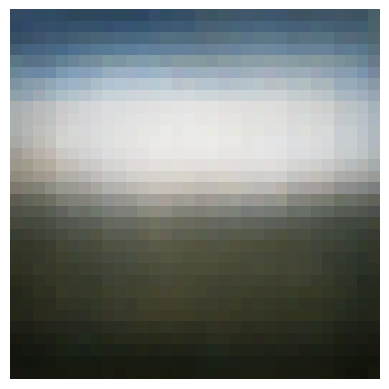

In [19]:
# Elegir una de las imágenes generadas para mostrar
image_to_show = decoded_images[0]

# Mostrar la imagen generada
plt.imshow(image_to_show)
plt.axis('off')
plt.show()

Este bloque de código elige una de las imágenes generadas por el modelo y la muestra visualmente. Si bien es cierto que no se distingue con claridad que hay en la imagen generada, podemos observar detalles claros como el cielo, nubes, y un posible bosque o montañas en la parte inferior de la imagen.

In [42]:
len(decoded_images)

871